# Investigating cross-league PC correlations

Similar to the cross-season case, I would like to see if the principal components are correlated if we take different leagues into conisderiation

To investigate, a dissimilarity score is introduced and heatmap plotted

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")

In [2]:
from feature_utils import load_season_data

start_year = 2017
leagues = np.array(['Premier League', 'La Liga', 'Serie A', 'Ligue 1', 'Bundesliga'])

season = f"{start_year}-{start_year+1}"

data = {league: load_season_data(league, season).query("pos != 'GK'") for league in leagues}

In [3]:
data['Serie A']

,season,team,nation,pos,age,90s,standard_sot%,standard_dist,expected_npxg/sh,aerial_duels_won%,...,succ_takeons_vs_team,carries_per_game_vs_team,distance_per_carry,prg_distance_per_carry,prg_distance_pct,prg_carry_pct,carries3rd_per_carries,carries_pa_per_carries,receives_per_game_vs_team,prgreceives_per_game_vs_team
player,,,,,,,,,,,,,,,,,,,,,
Franck Kessié,2017-2018,Milan,ci CIV,MF,20.0,36.3,26.8,19.1,0.06,40.2,...,0.893613,1.160172,5.302853,2.596196,0.489585,0.070227,0.048281,0.024140,1.072295,1.215743
Leonardo Bonucci,2017-2018,Milan,it ITA,DF,30.0,34.3,26.1,19.1,0.10,55.3,...,0.770309,1.208060,5.123420,3.233457,0.631113,0.019331,0.014126,0.000743,1.150421,0.103173
Ricardo Rodríguez,2017-2018,Milan,ch SUI,DF,24.0,33.4,21.4,27.1,0.03,50.0,...,1.325873,1.190804,5.511232,3.109992,0.564301,0.068939,0.052672,0.003098,1.121513,0.916186
Suso,2017-2018,Milan,es ESP,"FW,MF",23.0,31.4,39.4,24.3,0.05,30.8,...,0.853435,1.204839,6.425896,3.188111,0.496135,0.105049,0.066775,0.050489,1.175164,2.446298
Giacomo Bonaventura,2017-2018,Milan,it ITA,MF,27.0,28.2,46.0,20.2,0.07,45.9,...,0.924093,1.112139,5.816306,3.177800,0.546360,0.094303,0.071709,0.011788,1.128657,1.373019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sebastián Cristóforo,2017-2018,Fiorentina,uy URU,MF,23.0,3.0,0.0,26.3,0.05,55.6,...,1.565582,1.288168,4.237705,2.024590,0.477756,0.016393,0.016393,0.000000,1.397417,0.496732
Nenad Tomović,2017-2018,Fiorentina,rs SRB,DF,29.0,1.5,0.0,0.0,0.00,66.7,...,1.565582,1.245933,4.559322,2.559322,0.561338,0.016949,0.050847,0.000000,1.270379,0.165577
Khouma Babacar,2017-2018,Fiorentina,sn SEN,FW,24.0,5.0,52.4,18.7,0.11,35.3,...,0.671635,0.690543,6.238532,3.266055,0.523529,0.091743,0.045872,0.036697,0.664227,1.887582


----
----
----

Creating traning sets

In [4]:
MIN_90S = 5.0

X_trains = dict()
for league, data_df in data.items():
    X_train = data_df
    X_train = X_train[X_train['90s'] >= MIN_90S]
    X_train = X_train.iloc[:, 6:]
    X_trains[league] = X_train

### Running power season-specfic transform to normalize features 

In [5]:
from sklearn.preprocessing import PowerTransformer

power_transform = PowerTransformer(method='yeo-johnson')
power_transform.fit(X_trains['Premier League'])

X_trains_transformed = dict()
for league, train_df in X_trains.items():
    X_train_transformed = power_transform.transform(train_df)
    X_train_transformed = pd.DataFrame(index=train_df.index, columns=train_df.columns, data=X_train_transformed)
    X_trains_transformed[league] = X_train_transformed

### Distinct PCAs on transformed feature space every season

In [6]:
from sklearn.decomposition import PCA

pca_models = dict()
X_trains_decomposed = dict()

for league, train_df_transformed in X_trains_transformed.items():
    pca = PCA()
    X_train_decomposed = pca.fit_transform(train_df_transformed)
    X_train_decomposed = pd.DataFrame(index=train_df_transformed.index, columns=(f"PC{i}" for i in range(1, len(train_df_transformed.columns) + 1)), data=X_train_decomposed)
    X_trains_decomposed[league] = X_train_decomposed
    pca_models[league] = pca

## Investigating PC stability over different 2017-2018 leagues

Let's use season Premier League as a benchmark.

If we calculate the correlation between each PC within this league, we will obtain a diagonal matrix.

However, if we believe the PCs are somewhat stable - calculating correlations between different seasons should give us a matrix close to diagonal (meaning the PCs assign the exact same weights to describe the same things) - at least for the first leading PCs.

Important to bear in mind, that the explained variance can sometimes switch places, although the meaning will stay the same

In [7]:
baseline_league = 'Premier League'
compare_leagues = list(pca_models.keys())[1:]

N = 52  # Number of leading components to look at
corr_mats = dict()

for league in compare_leagues:
    pca_corr_mat = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            pc_corr = np.corrcoef(pca_models[baseline_league].components_[i], pca_models[league].components_[j])[0, 1]
            pca_corr_mat[i, j] = pc_corr
    
    corr_mats[league] = pca_corr_mat

In [8]:
corr_mats['La Liga'][:4, :4]

array([[ 0.98916557,  0.11982523,  0.00540944,  0.06681129],
       [-0.03415247,  0.98013709,  0.03397779, -0.26614897],
       [ 0.02883195,  0.06760949, -0.78220727, -0.55343436],
       [ 0.0276222 ,  0.22012613,  0.57795792, -0.78451492]])

In [9]:
corr_mats['Bundesliga'][:4, :4]

array([[ 0.98086728, -0.01084062,  0.05931184, -0.08221102],
       [ 0.05472557,  0.91962502, -0.25906915,  0.11522197],
       [ 0.09233599, -0.22126388, -0.80014042,  0.51658264],
       [-0.00471346,  0.2802577 , -0.52882973, -0.70567845]])

In [10]:
X_trains_decomposed['La Liga'].loc[['Marcelo']]

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52
player,,,,,,,,,,,,,,,,,,,,,
Marcelo,1.782004,-4.272535,-0.237257,-0.918458,0.113485,0.520213,-1.731822,-0.363658,0.721648,0.292018,...,-0.324264,-0.284134,0.164295,-0.140655,-0.039156,-0.012642,0.007503,-0.100322,0.058903,0.067129


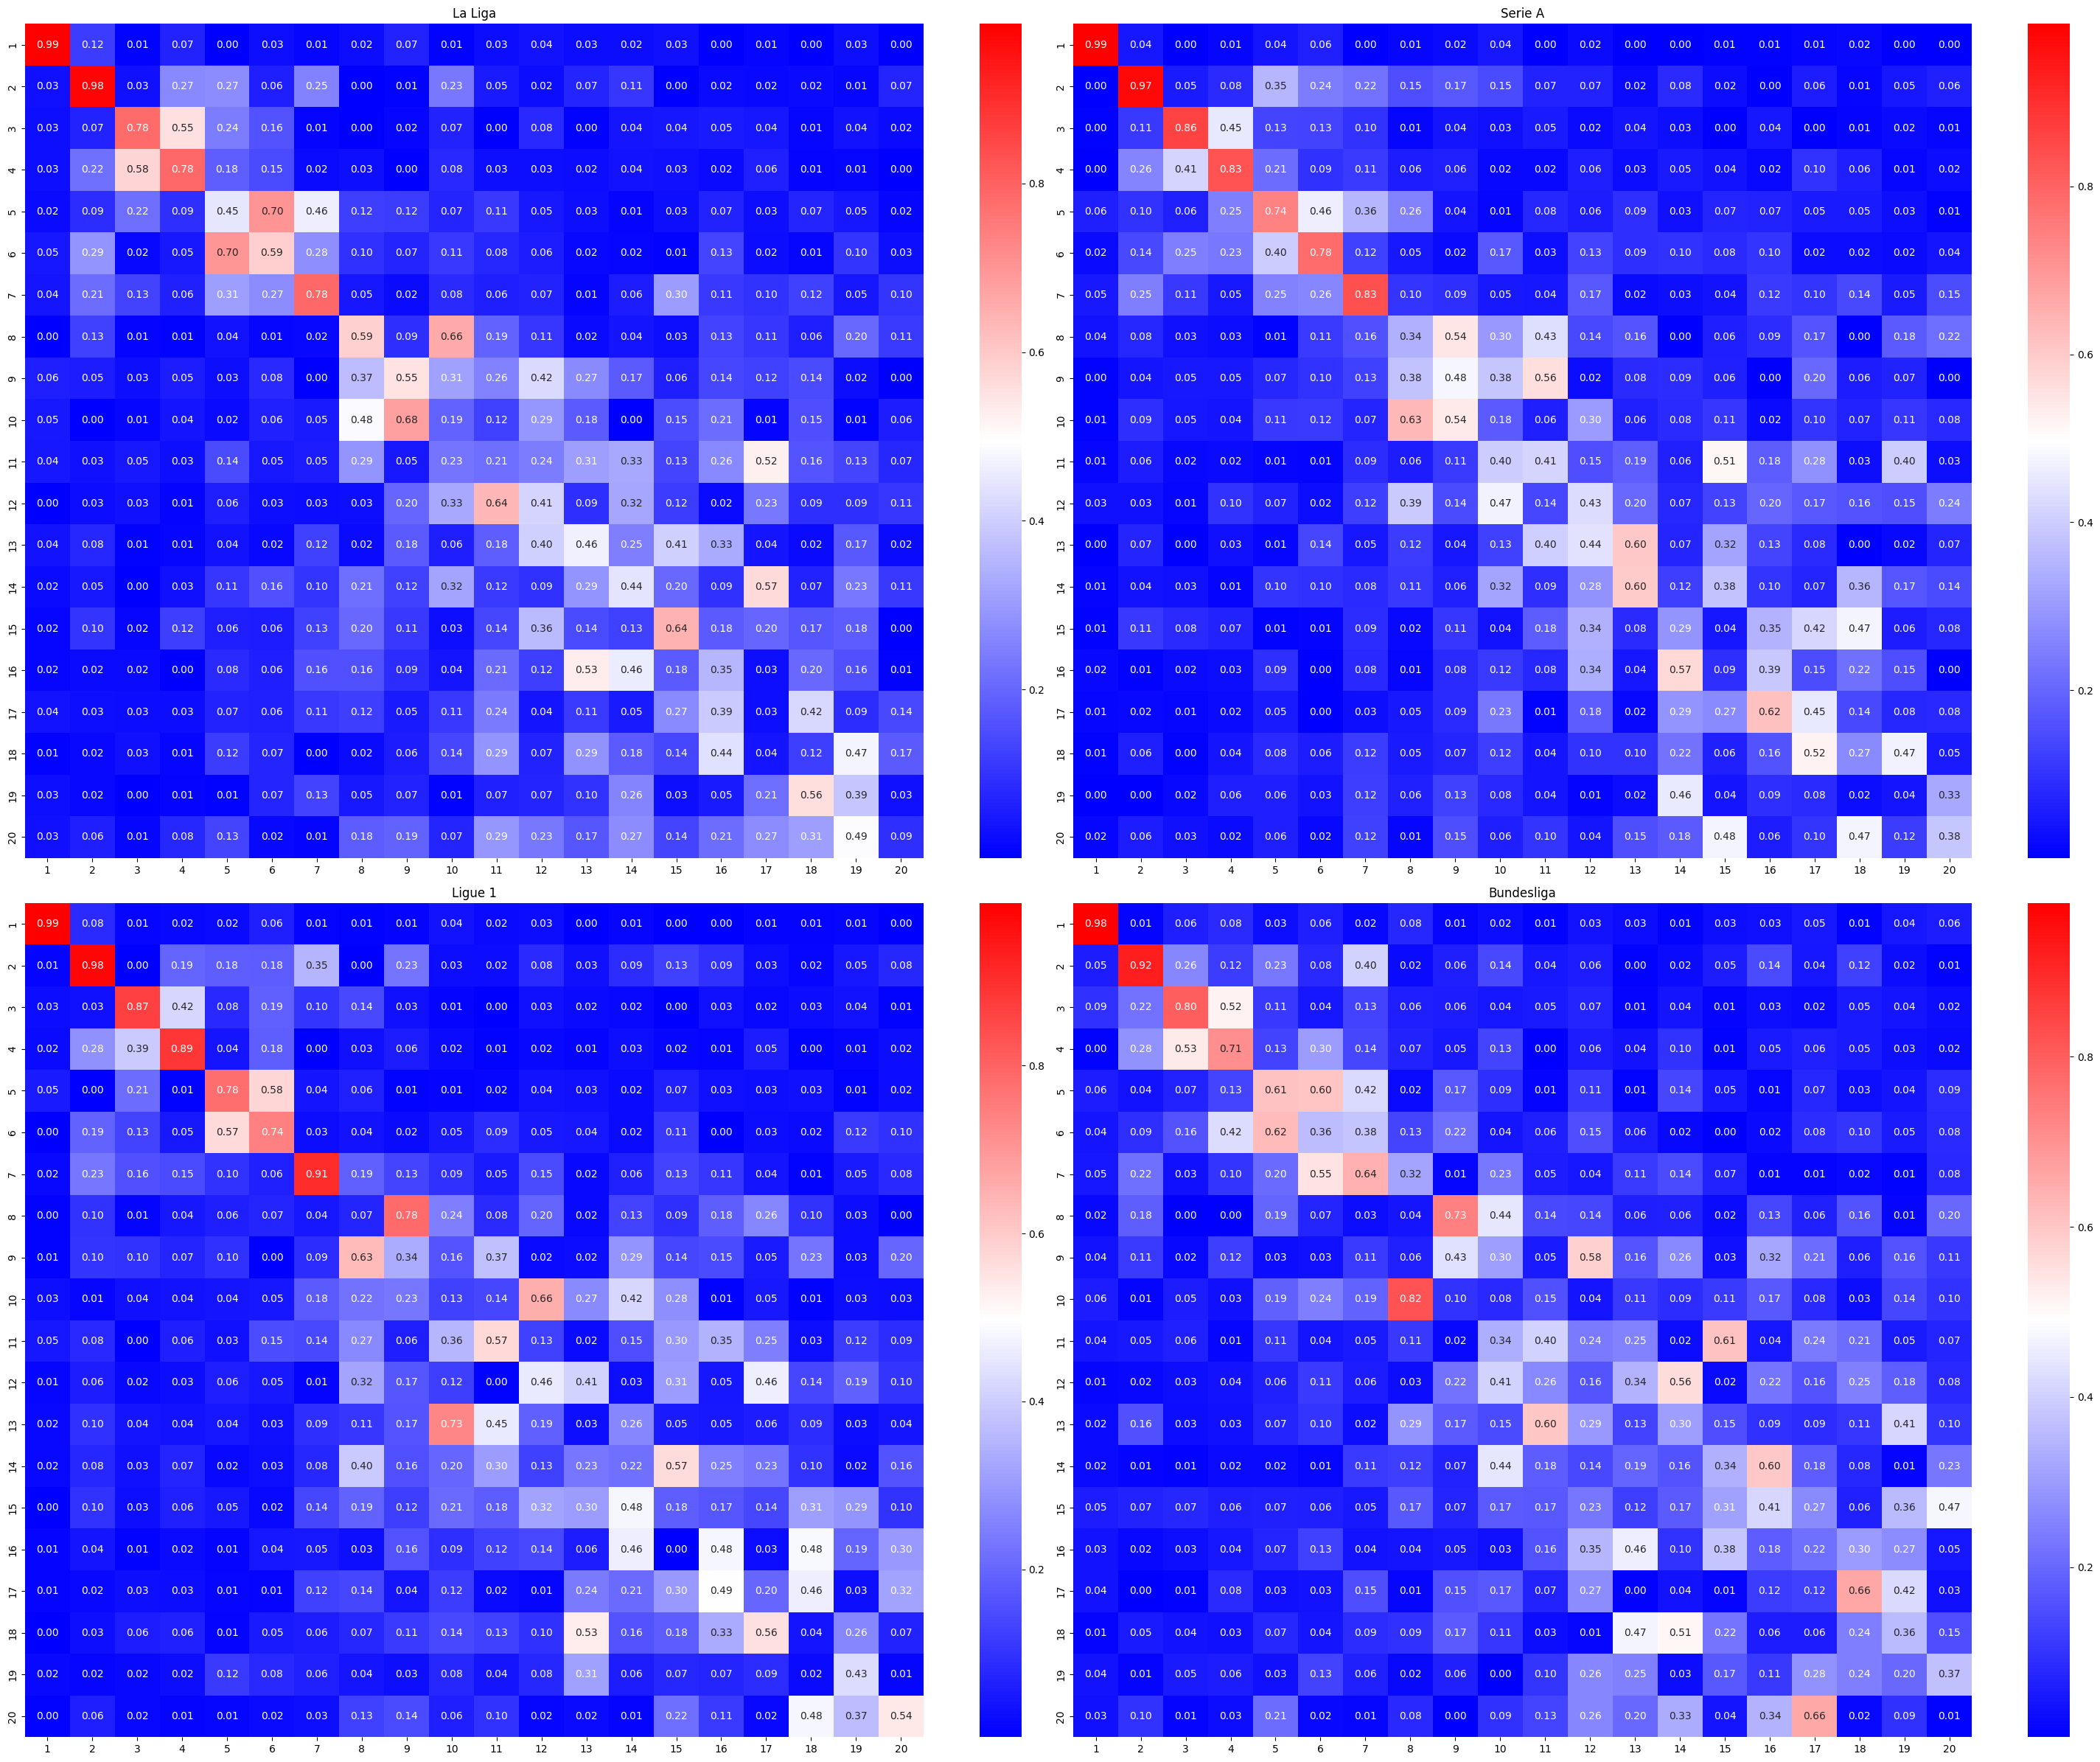

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(30, 24), tight_layout=True)
for i, (league, corr_mat) in enumerate(corr_mats.items()):
    row, col = i // 2, i % 2
    ax[row, col].set_title(league)
    sns.heatmap(np.abs(corr_mat[:20, :20]), annot=True, cmap='bwr', fmt=".2f", ax=ax[row, col])
    ax[row, col].set_xticks(np.arange(20) + 0.5)
    ax[row, col].set_yticks(np.arange(20) + 0.5)
    ax[row, col].set_xticklabels(np.arange(1, 21))
    ax[row, col].set_yticklabels(np.arange(1, 21))

plt.show()

To account for "flipping PC" I will find the correlations that make the most sense and pair them

In [12]:
import numpy as np

def find_highest_correlations(matrix):
    correlations = []

    while matrix.size > 1:
        # Find the indices of the maximum correlation value
        max_corr = np.max(matrix[0])
        max_corr_col = np.argmax(matrix[0])

        # Add the highest correlation along with its index to the list
        correlations.append(max_corr)

        # Remove the row and column corresponding to the highest correlation
        matrix = np.delete(matrix, 0, axis=0)
        matrix = np.delete(matrix, max_corr_col, axis=1)

    return correlations

In [13]:
corr_vectors = []
for corr_mat in corr_mats.values():
    corr_vector = find_highest_correlations(np.abs(corr_mat))
    corr_vectors.append(corr_vector)

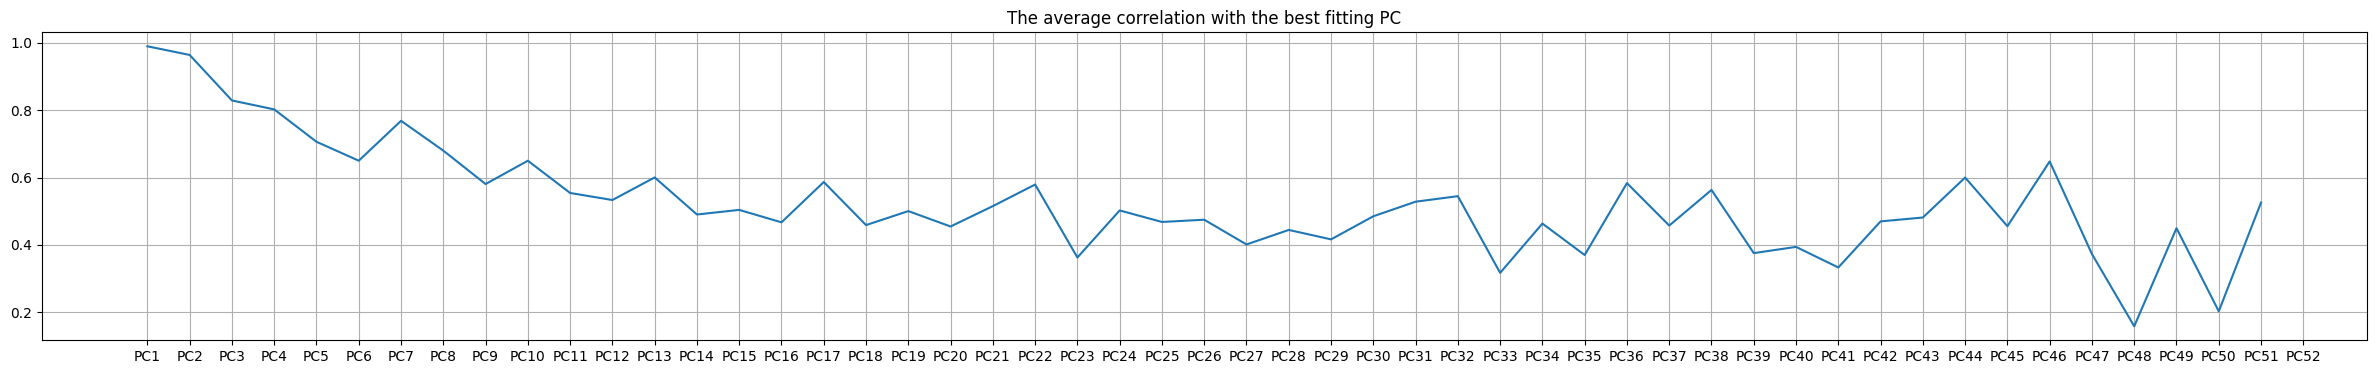

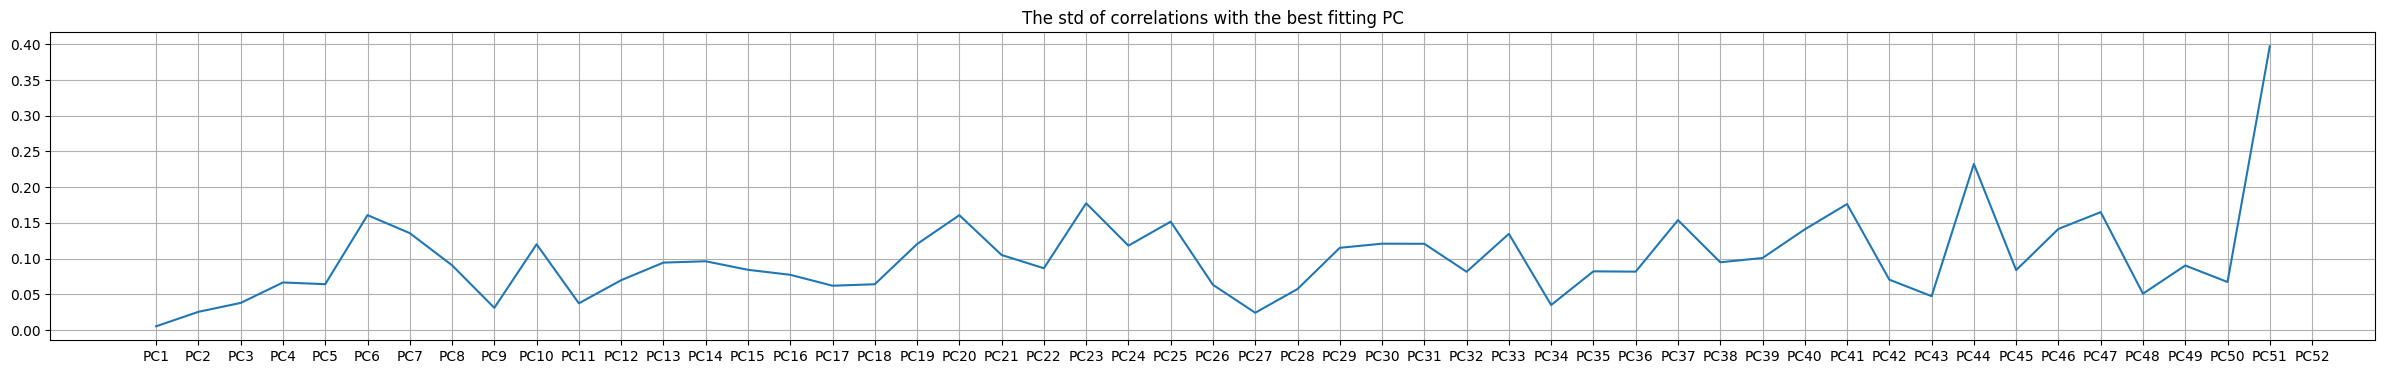

In [14]:
plt.figure(figsize=(30, 4))
plt.title("The average correlation with the best fitting PC")
plt.plot(np.mean(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.grid()
plt.show()

plt.figure(figsize=(30, 4))
plt.title("The std of correlations with the best fitting PC")
plt.plot(np.std(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.grid()
plt.show()

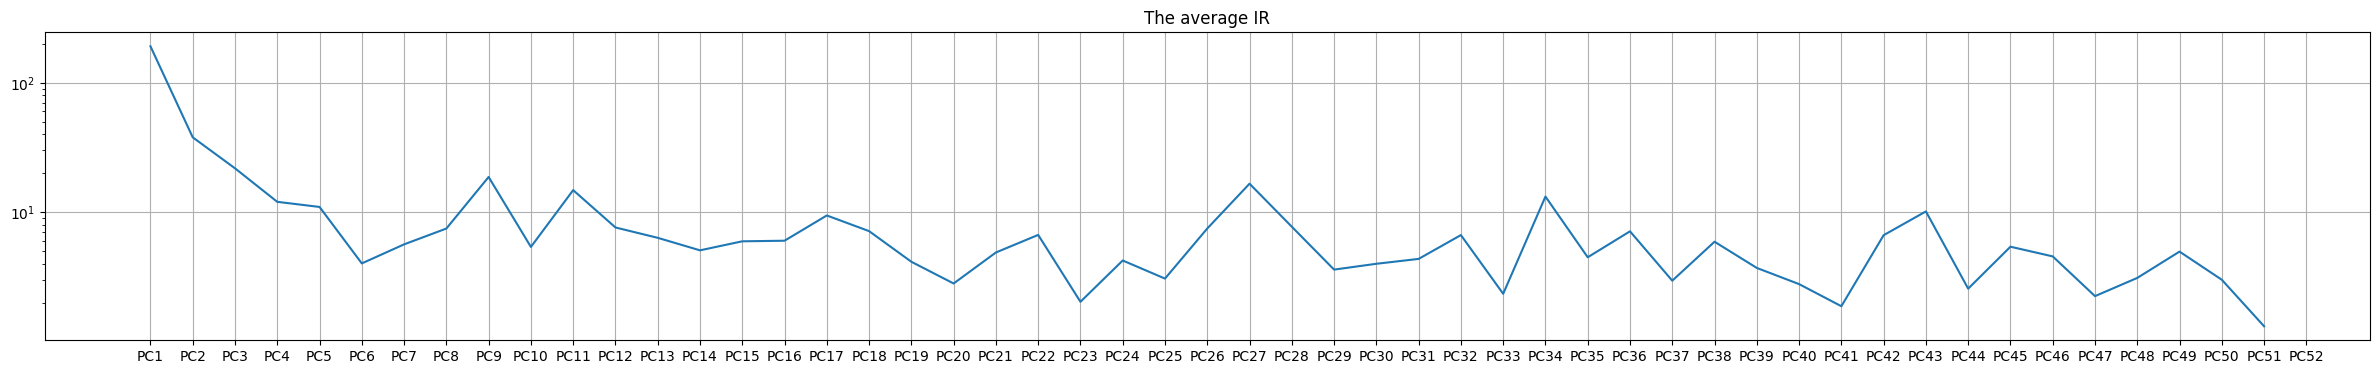

In [15]:
plt.figure(figsize=(30, 4))
plt.title("The average IR")
plt.plot(np.mean(corr_vectors, axis=0) / np.std(corr_vectors, axis=0))
plt.xticks(range(52), (f"PC{i}" for i in range(1, len(X_train.columns) + 1)))
plt.yscale('log')
plt.grid()
plt.show()